# Particle Tracking Code - Used for traction force microscopy

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python

%matplotlib notebook 
#note that the other option is %matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#Loading the particle tracking software
import sys
sys.path.append("..\\track") #Locate code
import mpretrack #The file mpretrack.py and trackmem.py should be in the location above
import trackmem
import bpass
import tiff_file #Ignore any warnings importing this may cause

C:\Users\rmcgorty\Documents\GitHub\ParticleTracking-Python\jupyter_notebooks\..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\ParticleTracking-Python\jupyter_notebooks\..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\ParticleTracking-Python\jupyter_notebooks\..\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


#### You may need to edit the location of the data in the cell below

In [2]:
#Now let's locate the data
data_directory = "C:\\Users\\rmcgorty\\Dropbox\\2023_Fall\\Phys381\\Tutorials\\Tutorial 03\\" #Notice the double slashes!
data_file = "images_tfm.tif"

### Let's inspect the data

We'll show the first frame of the movie we'll use. 
Then we'll show what that frame looks like when we filter it using a bandpass filter.


Text(0.5, 1.0, 'Image data filtered using bandpass filter')

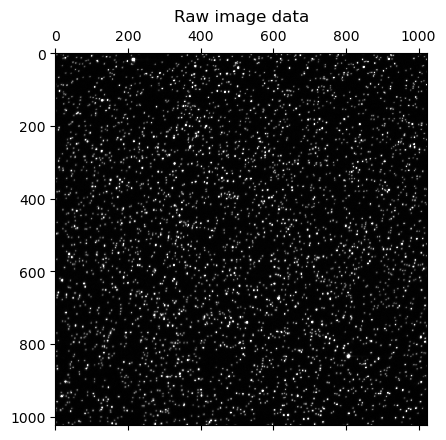

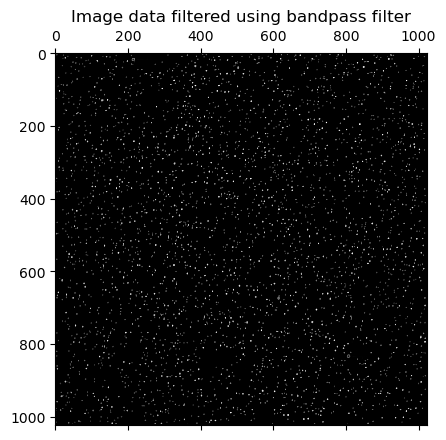

In [4]:
%matplotlib inline

#We use the "tiff_file" module to deal with image data in tif formats.
#The function 'imread' reads in the image. We can either read in the whole entire
#  movie or just read in a specific frame. Here, we are reading in only the first 
#  frame. We do this by setting the optional paratmer 'key' equal to 0. 
frame1_image = tiff_file.imread(data_directory+data_file,key=0)

plt.matshow(frame1_image, cmap=matplotlib.cm.gray) #'cmap' is the colormap used
plt.title("Raw image data")

#Let's try filtering the data with a bandpass filter. This filter is used when
#  identifying features in the image. 
bpass_image = bpass.bpass(frame1_image,1,3)

plt.matshow(bpass_image, cmap=matplotlib.cm.gray)
plt.title("Image data filtered using bandpass filter")



-----------TEST-----------
3392 features found.


C:\Users\rmcgorty\Documents\GitHub\ParticleTracking-Python\jupyter_notebooks\..\track\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


Intensity of 1st particle: 70353.88
Rg of 1st particle: 2.16
Eccentricity of 1st particle: 0.4215
[[4.06449335e+02 3.28109333e+00 7.03538810e+04 2.16177302e+00
  4.21482156e-01]
 [5.39777490e+02 3.77088721e+00 5.48214211e+04 2.34027087e+00
  1.68867650e-01]
 [6.09697288e+02 3.15888195e+00 3.30766903e+04 1.61097503e+00
  5.33376183e-01]
 ...
 [2.92326784e+02 1.01901204e+03 1.36240984e+05 2.61458676e+00
  1.52012295e-01]
 [3.90346027e+02 1.01844924e+03 9.00079110e+04 3.15707359e+00
  2.54700546e-02]
 [8.61171643e+02 1.01894034e+03 9.26256268e+04 2.49874008e+00
  1.13895326e-01]]


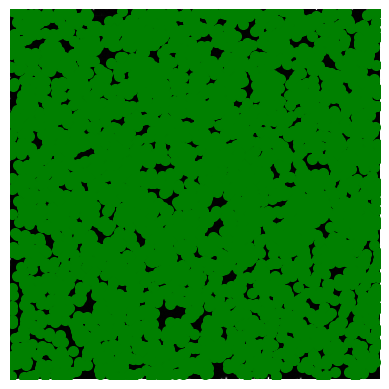

3392 features kept.
Minimum Intensity : 8632.276943709103
Maximum Rg : 5.019577007141967
Maximum Eccentricity : 0.9999999997866615
--------------------------


In [5]:
#Use the function 'test' in mpretrack to find good set of parameters

###############################################################################
# Options from mpretrack:
#    barI: minimum integrated intensity
#    barRg: maximum radius of gyration squared (in pixel squared)
#    barCc: minimum eccentricity accepted
#    IdivRg: minimum ratio of of integrated intensity to radius of gyr sqrd
#    Imin: minimum intensity of local max -- set to 0 to use default "top 30%"
#    masscut: threshold for integrated intesnity of features before refinement
#    field: 2 for full frame (0 or 1 if interlaced video)
###############################################################################

########## IMPORTANT ###########
# All of these paramters, and  #
# especially the feature_size, #
# will likely need adjusting.  #
################################

frame_num = 0 #We'll use the first frame
feature_size = 3
%matplotlib inline
mt, mrej = mpretrack.test(data_directory,data_file,frame_num,feature_size,
                          masscut = 500, Imin=3000, barI = 100, barRg = 11,
                          barCc = None, IdivRg=1.0, verbose=True, bandpass='bp');

Did that look okay? You should see a figure appear with green dots where the program found particles. Red dots indicate that particles were identified but then discarded due to not meeting the thresholds (like being below the minimum integrated intensity or exceeding the maximum radius of gyration).

Now we'll run the feature-finding algorithm with the paramters we found on *all* frames.

In [7]:
num_frames = 2 #number of frames to find particles

#Same parameters used as in "test".
#NOTE: I set verbose=False here so it doesn't print out too much 
#But you should set verbose=True. 
#It will then print out how many particles found in each frame.
mt = mpretrack.run(data_directory,data_file,num_frames,feature_size,
                   masscut = 500, Imin=3000, barI = 100, barRg = 11,
                   barCc = None, IdivRg=1.0, verbose=False, bandpass='bp')

Frame 0


In each frame, the code has identified particles (i.e., features). Now we have to link them together into "tracks."


In [41]:
### Tracking with fancytrack:
num_dimensions = 2 #We take 2-dimensional images
max_displacement = 7 #Maximum displacement between consecutive frames to count as same particle
goodenough = 2 #Minimum length for trajectory
memory = 1 #how many consecutive frames a feature is allowed to skip. 
tracks = trackmem.trackmem(mt, max_displacement, num_dimensions, goodenough, memory)

What's in <code>tracks</code>?
+ <code>tracks[:,0]</code> is the *x*-coordinate of particle (in terms of pixel)
+ <code>tracks[:,1]</code> is the *y*-coordinate
+ <code>tracks[:,2]</code> is the integrated brightness of found features
+ <code>tracks[:,3]</code> is the square of the radius of gyration
+ <code>tracks[:,4]</code> is the eccentricity (zero for circularly symmetric features)
+ <code>tracks[:,5]</code> is the frame number
+ <code>tracks[:,6]</code> is the time
+ <code>tracks[:,7]</code> is the trajectory ID number

Let's look at how many trajectories we've found, what the length of some of these trajectories are and what they look like superimposed on an image of the beads.

In [42]:
#The last element in the each "track" is the track ID number. It starts at one. 
# So finding the maximum of the track ID number will tell us how many tracks
# there are. 
print("Number of trajectories: %i" % tracks[:,7].max())

Number of trajectories: 3207


In [43]:
#Just to get a sense of the length of the trajectories.
#Printing the lenghts by funding all instances where the track ID
#  number is 1, 2, 3. 

print("Length of 1st trajectory: %i" % np.sum(tracks[:,7]==1))
if tracks[:,7].max()>1: #this checks to make sure there is a track ID 2
    print("Length of 2nd trajectory: %i" % np.sum(tracks[:,7]==2))
if tracks[:,7].max()>2:
    print("Length of 3rd trajectory: %i" % np.sum(tracks[:,7]==3))

Length of 1st trajectory: 2
Length of 2nd trajectory: 2
Length of 3rd trajectory: 2


Let's check for pixel biasing. By making a histogram of the mantissa of the positions (done using the [modulus function in numpy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mod.html)). 

Ideally, this histogram will look flat. That would indicate that finding a particle at *x* = 3.4 is just as likely as finding it at *x* = 3.0. 

If pixel biasing is occuring, you'll see that, for instance, a particle at *x* = 3.0 is more likely than at *x* = 3.5. If you see pixel biasing occuring, you may need to check the <code>feature_size</code> parameter in the tracking code. You can also check that the bandpass filter is being used.

(array([397., 416., 384., 388., 402., 418., 433., 446., 427., 447., 449.,
        446., 440., 462., 469., 426., 457., 433., 436., 448., 458., 448.,
        428., 417., 416., 401., 408., 401., 396., 431.]),
 array([0.        , 0.03332906, 0.06665811, 0.09998717, 0.13331623,
        0.16664528, 0.19997434, 0.2333034 , 0.26663245, 0.29996151,
        0.33329057, 0.36661962, 0.39994868, 0.43327774, 0.46660679,
        0.49993585, 0.53326491, 0.56659396, 0.59992302, 0.63325208,
        0.66658113, 0.69991019, 0.73323925, 0.7665683 , 0.79989736,
        0.83322642, 0.86655547, 0.89988453, 0.93321359, 0.96654264,
        0.9998717 ]),
 <BarContainer object of 30 artists>)

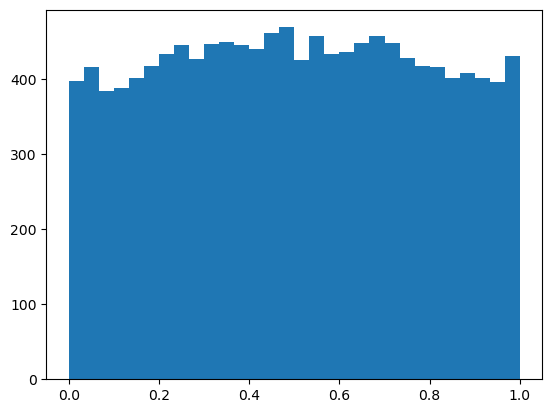

In [44]:
plt.figure()
plt.hist(np.hstack((np.mod(tracks[:,0],1), np.mod(tracks[:,1],1))), bins=30) #plotting histogram

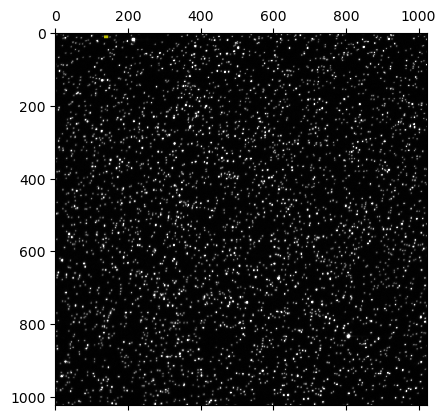

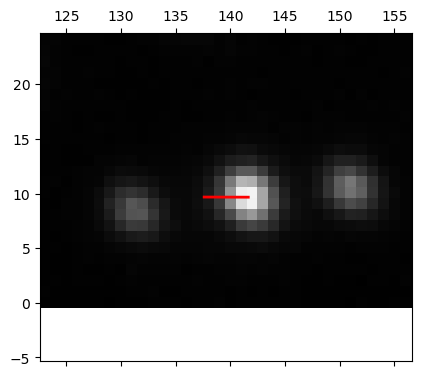

In [45]:
%matplotlib inline

frame1_image = tiff_file.imread(data_directory+data_file,key=0) #read in first frame

#Sometimes images need to be flipped upside down. If that's the case, change False to True
if False:
    plt.matshow(np.flipud(frame1_image), cmap=matplotlib.cm.gray) #not sure why I need the flipud but seem to
else:
    plt.matshow(frame1_image, cmap=matplotlib.cm.gray)

#Locate track ID 37 (that's just one I found that looks okay)
w = np.where(tracks[:,7]==37)

plt.plot(tracks[w[0],0],tracks[w[0],1],'-y',lw=2) #drawing the trajectory with a yellow line

#Show same thing but zoom in on the track
if False:
    plt.matshow(np.flipud(frame1_image), cmap=matplotlib.cm.gray) #not sure why I need the flipud but seem to
else:
    plt.matshow(frame1_image, cmap=matplotlib.cm.gray)
plt.plot(tracks[w[0],0],tracks[w[0],1],'-r',lw=2)
plt.xlim(tracks[w[0],0].min()-15,tracks[w[0],0].max()+15); #Setting the x-limits for the figure. I'm zooming in on the bead in question
plt.ylim(tracks[w[0],1].min()-15,tracks[w[0],1].max()+15); #Setting y-limits

In [46]:
###############################################################################################
######### Computing the displacementd #########################################################
###############################################################################################

#Array of x,y position and x,y displacements
position_and_displacements = np.zeros((int(tracks[:,7].max()),4)) 

#Here, we loop over every particle
for i in range(1,int(tracks[:,7].max()+1)):
    w1 = np.where(tracks[:,7]==i) #Find the locations in the matrix for given particle
    w2 = np.where(tracks[w1[0],5]==0) #Find where the frame number is 1
    w3 = np.where(tracks[w1[0],5]==1) #Find where the frame number is 2

    position_and_displacements[i-1,0] = tracks[w1[0][w2[0]],0]
    position_and_displacements[i-1,1] = tracks[w1[0][w2[0]],1]
    
    #Compute the displacements
    xdisp = tracks[w1[0][w3[0]],0] - tracks[w1[0][w2[0]],0]
    ydisp = tracks[w1[0][w3[0]],1] - tracks[w1[0][w2[0]],1]

    
    position_and_displacements[i-1,2] = xdisp
    position_and_displacements[i-1,3] = ydisp
    

mean_xdisp = position_and_displacements[:,2].mean()
mean_ydisp = position_and_displacements[:,3].mean()

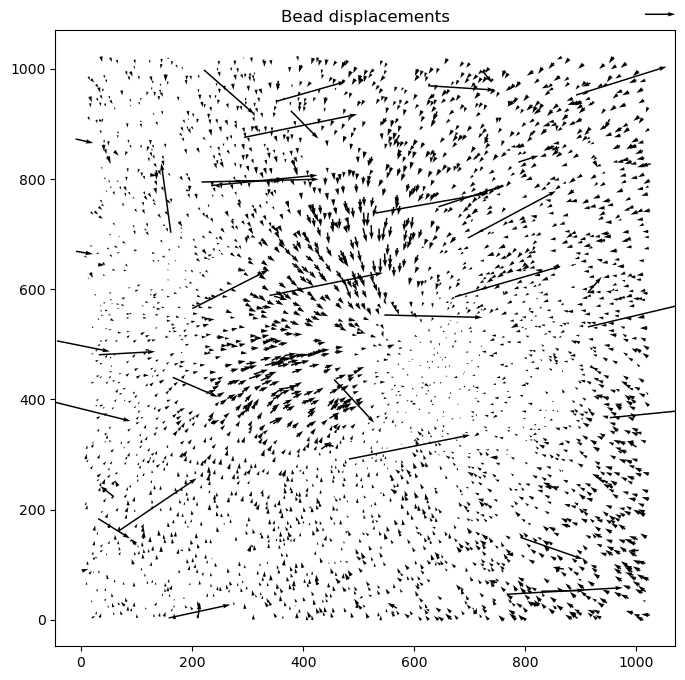

In [48]:
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.set_title('Bead displacements')
Q = ax1.quiver(position_and_displacements[:,0], position_and_displacements[:,1], 
               position_and_displacements[:,2] - mean_xdisp, position_and_displacements[:,3] - mean_ydisp, 
               units='width', pivot='mid')
qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')